![pew pew](https://raw.githubusercontent.com/dotabuff/d2vpk/master/dota_pak01/resource/flash3/images/items/dagon_5.png)


# NYX NYX NYX 

So I sumbled a upon a thread on reddit discussing nyx damage, and how you shouldn't upgrade dagon past lvl 1.
Can we trust OP ?
 
Image below. http://www.reddit.com/r/DotA2/comments/35u0h2/kill_with_nyx_like_a_pro_know_your_limits_damage/

![kappa](http://i.imgur.com/X3gjETd.jpg)

The manacost for dagon is flat for all levels and so is the damage increase. However, the cooldown decreasaes, which should provide higher DPS, if you have the mana. Naturally, a low level hero shouldn't be able to make use of the low cooldown , since they run out of mana quickly. Let's get the numbers in.

I will fetch the numbers straight from the game files. Dotabuff have a git repository tracking the game file changes, which is more convinent to access, so I will use that. Usually, it's up to date.

In [1]:
%pylab inline
import vdf
import requests
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = [12.0,4.0]

items = vdf.loads(requests.get("https://raw.githubusercontent.com/dotabuff/d2vpk/master/dota_pak01/scripts/npc/items.txt").content)
skills = vdf.loads(requests.get("https://raw.githubusercontent.com/dotabuff/d2vpk/master/dota_pak01/scripts/npc/npc_abilities.txt").content)
heroes = vdf.loads(requests.get("https://raw.githubusercontent.com/dotabuff/d2vpk/master/dota_pak01/scripts/npc/npc_heroes.txt").content)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Since there are many variables at play, I will define some classes to make working with the data more convinent

class Hero:
    # every hero has this basic stats
    base_hp = 150
    base_mana = 0
    base_armor = 0
    
    # constants
    str_hp_per_pt = 19
    str_regen_per_pt = 0.03
    agi_armor_per_pt = 0.14
    agi_speed_per_pt = 1
    int_mana_per_pt = 14
    int_mana_regen_per_pt = 0.04
    
    def __init__(self, hero_dict):
        self.hero = hero_dict 
        
    def get_str(self, level=1):
        strn = float(self.hero['AttributeBaseStrength'])
        strn += float(self.hero['AttributeStrengthGain']) * (level-1)
        return strn
    
    def get_agi(self, level=1):
        agi = float(self.hero['AttributeBaseAgility'])
        agi += float(self.hero['AttributeAgilityGain']) * (level-1)
        return agi
    
    def get_int(self, level=1):
        inte = float(self.hero['AttributeBaseIntelligence'])
        inte += float(self.hero['AttributeIntelligenceGain']) * (level-1)
        return inte
    
    def get_hp(self, level=1):
        hp = self.base_hp 
        hp += self.get_str(level) * self.str_hp_per_pt
        return hp          
    def get_hp_regen(self, level=1):
        regen = float(self.hero['StatusHealthRegen'])
        regen += self.get_str(level) * self.str_regen_per_pt
        return regen 
    
    def get_mana(self, level=1):
        mana = self.base_mana
        mana += self.get_int(level) * self.int_mana_per_pt
        return mana
    
    def get_armor(self, level=1):
        armor = float(self.hero['ArmorPhysical']) + self.base_armor
        armor += self.get_agi(level) * self.agi_armor_per_pt
        return armor
    
    def get_armor_multiplier(self, level=1):
        armor = self.get_armor(level)
        return 1 - 0.06 * armor / (1 + 0.06 * abs(armor))
    
class Dagon:
    def __init__(self, items):
        self.dagon = items['DOTAAbilities']['item_dagon']
        self.AS = reduce(lambda a,b: dict(a, **b), self.dagon['AbilitySpecial'].values())
    
    def select_for_level(self, value, level):
        arr = value.split(' ')
        if len(arr) is 1:
            return value
        else:
            return arr[level-1]

    def get_manacost(self, level=1):
        return float(self.select_for_level(self.dagon['AbilityManaCost'], level))
    def get_cooldown(self, level=1):
        return float(self.select_for_level(self.dagon['AbilityCooldown'], level))
    def get_int(self, level=1):
        return float(self.select_for_level(self.AS['bonus_intellect'], level))
    def get_damage(self, level=1):
        return float(self.select_for_level(self.AS['damage'], level))
    
def skill_manacost(name, level=1):
    if level < 1:
        return 0
    arr = skills['DOTAAbilities'][name].get('AbilityManaCost', '0').split(' ')
    return float(arr[0] if len(arr) is 1 else arr[level-1])

In [3]:
dagon = Dagon(items)
nyx = Hero(heroes['DOTAHeroes']['npc_dota_hero_nyx_assassin'])

# We are ready to crunch the numbers

First lets look at the damage and mana requirements of Dagon.

In [4]:
for level in range(1,6):
    damage = dagon.get_damage(level)
    # damage per minute
    dpm = (damage / dagon.get_cooldown(level)) * 60
    dpm = str(int(dpm)).rjust(4)
    mana = dagon.get_manacost(level)
    mpm = (dagon.get_manacost(level) / dagon.get_cooldown(level)) * 60
    
    print "Dagon level: %(level)d   Damage: %(damage)d (%(mana)d manacost)  DPM: %(dpm)s  Mana required per min: %(mpm)d" % locals()

Dagon level: 1   Damage: 400 (180 manacost)  DPM:  685  Mana required per min: 308
Dagon level: 2   Damage: 500 (180 manacost)  DPM: 1000  Mana required per min: 360
Dagon level: 3   Damage: 600 (180 manacost)  DPM: 1440  Mana required per min: 432
Dagon level: 4   Damage: 700 (180 manacost)  DPM: 2100  Mana required per min: 540
Dagon level: 5   Damage: 800 (180 manacost)  DPM: 3200  Mana required per min: 720


As espected, the lower cooldown drastically increases the damage per minute and mana requirements.
Now lets put these numbers into prespective by looking at the mana pool of a naked nyx ( ͡° ͜ʖ ͡°) at all levels, and compare with the mana required for the combos.

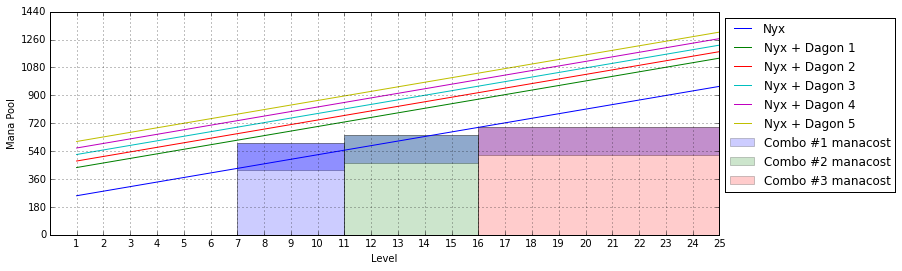

In [5]:
matrix = {
    1: {
        "range": (7,12),
        "combo": {
            "nyx_assassin_impale": 4,
            "nyx_assassin_mana_burn": 1,
            "nyx_assassin_vendetta": 1,
        }
    },
    2: {
        "range": (11,17),
        "combo": {
            "nyx_assassin_impale": 4,
            "nyx_assassin_mana_burn": 4,
            "nyx_assassin_vendetta": 2,
        }
    },
    3: {
        "range": (16,26),
        "combo": {
            "nyx_assassin_impale": 4,
            "nyx_assassin_mana_burn": 4,
            "nyx_assassin_vendetta": 3,
        }
    },
}

# naked nyx
x = range(1,26)
y = map(lambda level: nyx.get_mana(level), x)
plt.plot(x, y, label="Nyx")

# nyx with dagons
for level in range(1,6):
    y2 = map(lambda mana: mana + dagon.get_int(level) * Hero.int_mana_per_pt, y)
    plt.plot(x, y2, label="Nyx + Dagon %d" % level)
    
# manacost of combos from the proposed table
for column, data in matrix.items():
    x2 = range(*data['range'])
    
    manacost = sum([skill_manacost(name, level) for name, level in data['combo'].items()])
    y2 = [manacost + dagon.get_manacost(1)] * len(x2)
    
    plt.fill([x2[0]] + x2 + [x2[-1]],  # how do i polygons?
             [0.0] + y2 + [0.0],  # polygons nyx nyx nyx
             alpha=0.2,
             label="Combo #%d manacost" % column)
    
    plt.fill_between([x2[0]] + x2 + [x2[-1]], # nyx
                     [0.0] + y2 + [0.0],
                     [0.0] + map(lambda mana: mana - dagon.get_manacost(1), y2) + [0.0],
                     alpha=0.3)

plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.xticks(x)
plt.yticks( range(0, 1500, int(dagon.get_manacost(1))) )
plt.ylabel("Mana Pool")
plt.xlabel("Level")
plt.grid(True)
plt.show()


_Note: the darker area is the combo + dagon 1_  
The manacost axis is in steps of the manacost for dagon, so that is obvious how many dagon uses are possible.

![](http://i.imgur.com/X3gjETd.jpg)

Remember that high DPM as upgrade dagon? Well, what is the point of having dagon on low cooldown, if you don't have the mana to use it? As you can see the combos exhausts your entire mana pool. This solidifies OPs statement that rushing dagon is plain stupid, even if you are doing well, other items are clearly a better choice. Think Blink Dagger or Ethereal Blade. Keep in mind that this is all situational, and depends on hero compositions (see table below). Ethereall Blade is not that easy to get. 

# Conclusion

DON'T BE AN IDIOT, DONT RUSH TO UPGRADE DAGON



# Best combo targets

* The values in the following are overestimates, as the heroes are assumed naked, which should be false in reality.  
* 25% resistance is assumed for all heroes, which is also not true (e.g. AntiMage, Visage, Rubick etc)
* The HP pool and armor values are calculated form the hero level (e.g. level 7 for the first combo)
* format: **{percent of hp}% ({damage after reduction})**

In [6]:
from IPython.display import HTML

def select_level(value, level=1):
    arr = value.split(' ')
    return float(value if len(arr) is 1 else arr[level-1])

html = """
<style>
#heroTable, #heroTable tr { border: 1px solid #ccc !important; }
</style>
<table id="heroTable">
<tr>
    <th></th>
"""
for column, data in matrix.items():
    html += "<th>Combo #%d (%d lvl)</th><th>+dagon1</th>" % (column, data['range'][0])
    
html += "</tr>\n"

row_start = """
<tr>
    <td>
        <img style="width:50px;display:inline-block;" src='https://raw.githubusercontent.com/dotabuff/d2vpk/master/dota_pak01/resource/flash3/images/heroes/%(hero_image)s.png'>
        %(hero_name)s
"""
row_end = """
    </td>
</tr>
"""
damage_matrix = []

# generate table with damage per hero
for hero_id, hero_dict in heroes['DOTAHeroes'].items():
    if 'Portrait' not in hero_dict:
        continue
        
    hero = Hero(hero_dict)
    
    row = [hero_id]
  
    # calculate combos
    for c, data in matrix.items():
        hero_level = data['range'][0]
        damage = 0
        
        for name, level in data['combo'].items():
            if name == "nyx_assassin_impale":
                damage += select_level(skills['DOTAAbilities'][name].get('AbilityDamage'), level) * 0.75
            elif name == "nyx_assassin_vendetta":
                tmp = select_level(skills['DOTAAbilities'][name]['AbilitySpecial']['04']['bonus_damage'], level)
                damage += tmp * hero.get_armor_multiplier(hero_level)
            elif name == "nyx_assassin_mana_burn":
                tmp = select_level(skills['DOTAAbilities'][name]['AbilitySpecial']['01']['float_multiplier'], level)
                damage += hero.get_int(hero_level) * tmp * 0.75     
        
        damage_w_dagon = damage + dagon.get_damage(1)*0.75
        hp_percent = (damage / hero.get_hp(hero_level)) * 100
        hp_precept_dagon = (damage_w_dagon / hero.get_hp(hero_level)) * 100
        
        row += ["%(hp_percent)d%% (%(damage)d)" % locals()]
        row += ["%(hp_precept_dagon)d%% (%(damage_w_dagon)d)" % locals()]
    
    damage_matrix.append(row)

damage_matrix = sorted(damage_matrix, reverse=True, key=lambda row: row[1])
        
for row in damage_matrix:
    hero_id = row[0]
    row = row[1:]
    hero_dict = heroes['DOTAHeroes'][hero_id]       
    hero_image = hero_id.replace("npc_dota_hero_","")
    hero_name = hero_dict['url'].replace('_', ' ')
    
    # row start - hero name and icon
    html += row_start % locals()
    
    for line in row:
        html += "<th>%s</th>" % line
        
    # row end
    html += row_end
    
    
html += "</table>"
HTML(html)